<a href="https://colab.research.google.com/github/dkomlen/finance-ml/blob/main/Dimensionality_reduction_Bitcoin_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 2. Getting started

#### 2.1. Loading packages

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier

from mpl_toolkits.mplot3d import Axes3D

import re
from collections import OrderedDict
from time import time
import sqlite3       

from scipy.linalg import svd   
from scipy import stats
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

from IPython.html.widgets import interactive, fixed

#### 2.2. Loading the data

In [35]:
# dataset = pd.read_csv('https://raw.githubusercontent.com/tatsath/fin-ml/master/Chapter%206%20-%20Sup.%20Learning%20-%20Classification%20models/CaseStudy3%20-%20Bitcoin%20Trading%20Strategy/BitstampData_sample.csv')
dataset = pd.read_csv('BitstampData.csv')

In [36]:
#Disable the warnings
import warnings
warnings.filterwarnings('ignore')

### 3. Exploratoriy data analyisis

#### 3.1. Descriptive statistics

In [37]:
dataset.shape

(2841377, 8)

In [38]:
# peek at data
set_option('display.width', 100)
dataset.tail(5)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
2841372,1496188560,2190.49,2190.49,2181.37,2181.37,1.700,3723.785,2190.247
2841373,1496188620,2190.50,2197.52,2186.17,2195.63,6.561,14402.812,2195.206
2841374,1496188680,2195.62,2197.52,2191.52,2191.83,15.663,34361.024,2193.792
2841375,1496188740,2195.82,2216.00,2195.82,2203.51,27.090,59913.493,2211.621
2841376,1496188800,2201.70,2209.81,2196.98,2208.33,9.962,21972.309,2205.649


In [39]:
set_option('precision', 3)
dataset.describe()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,2.841e+06,1.651e+06,1.651e+06,1.651e+06,1.651e+06,1.651e+06,1.651e+06,1.651e+06
mean,1.411e+09,4.959e+02,4.962e+02,4.955e+02,4.959e+02,1.188e+01,5.316e+03,4.959e+02
std,4.938e+07,3.642e+02,3.645e+02,3.639e+02,3.643e+02,4.094e+01,1.998e+04,3.642e+02
min,1.325e+09,3.800e+00,3.800e+00,1.500e+00,1.500e+00,0.000e+00,0.000e+00,3.800e+00
25%,1.368e+09,2.399e+02,2.400e+02,2.398e+02,2.399e+02,3.828e-01,1.240e+02,2.399e+02
50%,1.411e+09,4.200e+02,4.200e+02,4.199e+02,4.200e+02,1.823e+00,6.146e+02,4.200e+02
75%,1.454e+09,6.410e+02,6.417e+02,6.402e+02,6.410e+02,8.028e+00,3.108e+03,6.410e+02
max,1.496e+09,2.755e+03,2.760e+03,2.752e+03,2.755e+03,5.854e+03,1.866e+06,2.754e+03


### 4. Data preparation

#### 4.1.Data cleaning

In [40]:
dataset.isna().sum()

Timestamp                  0
Open                 1190473
High                 1190473
Low                  1190473
Close                1190473
Volume_(BTC)         1190473
Volume_(Currency)    1190473
Weighted_Price       1190473
dtype: int64

In [41]:
dataset = dataset.ffill()

In [42]:
dataset.describe()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,2.841e+06,2.841e+06,2.841e+06,2.841e+06,2.841e+06,2.841e+06,2.841e+06,2.841e+06
mean,1.411e+09,3.819e+02,3.822e+02,3.817e+02,3.819e+02,1.121e+01,3.478e+03,3.819e+02
std,4.938e+07,3.598e+02,3.601e+02,3.596e+02,3.598e+02,3.729e+01,1.563e+04,3.598e+02
min,1.325e+09,3.800e+00,3.800e+00,1.500e+00,1.500e+00,0.000e+00,0.000e+00,3.800e+00
25%,1.368e+09,9.351e+01,9.358e+01,9.349e+01,9.350e+01,4.040e-01,5.480e+01,9.350e+01
50%,1.411e+09,3.184e+02,3.186e+02,3.181e+02,3.184e+02,2.000e+00,2.631e+02,3.184e+02
75%,1.454e+09,5.878e+02,5.880e+02,5.875e+02,5.878e+02,8.420e+00,1.509e+03,5.877e+02
max,1.496e+09,2.755e+03,2.760e+03,2.752e+03,2.755e+03,5.854e+03,1.866e+06,2.754e+03


In [43]:
dataset = dataset.drop(columns=['Timestamp'])

#### 4.2. Preparing the data for classification

In [44]:
dataset['short_mavg'] = dataset['Close'].rolling(window=10, min_periods=1, center=False).mean()
dataset['long_mavg'] = dataset['Close'].rolling(window=60, min_periods=1, center=False).mean()

# signal = 1 if short term price will go up as compared to the long term.
dataset['signal'] = np.where(dataset['short_mavg'] > dataset['long_mavg'], 1.0, 0.0)

In [45]:
dataset.describe()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,short_mavg,long_mavg,signal
count,2.841e+06,2.841e+06,2.841e+06,2.841e+06,2.841e+06,2.841e+06,2.841e+06,2.841e+06,2.841e+06,2.841e+06
mean,3.819e+02,3.822e+02,3.817e+02,3.819e+02,1.121e+01,3.478e+03,3.819e+02,3.819e+02,3.819e+02,5.008e-01
std,3.598e+02,3.601e+02,3.596e+02,3.598e+02,3.729e+01,1.563e+04,3.598e+02,3.598e+02,3.598e+02,5.000e-01
min,3.800e+00,3.800e+00,1.500e+00,1.500e+00,0.000e+00,0.000e+00,3.800e+00,4.140e+00,4.140e+00,0.000e+00
25%,9.351e+01,9.358e+01,9.349e+01,9.350e+01,4.040e-01,5.480e+01,9.350e+01,9.352e+01,9.353e+01,0.000e+00
50%,3.184e+02,3.186e+02,3.181e+02,3.184e+02,2.000e+00,2.631e+02,3.184e+02,3.184e+02,3.184e+02,1.000e+00
75%,5.878e+02,5.880e+02,5.875e+02,5.878e+02,8.420e+00,1.509e+03,5.877e+02,5.877e+02,5.876e+02,1.000e+00
max,2.755e+03,2.760e+03,2.752e+03,2.755e+03,5.854e+03,1.866e+06,2.754e+03,2.750e+03,2.741e+03,1.000e+00


#### 4.3. Feature Engineering

* Moving Average : A moving average provides an indication of the trend of the price movement by cut down the amount of "noise" on a price chart.
* Stochastic Oscillator %K and %D : A stochastic oscillator is a momentum indicator comparing a particular closing price of a security to a range of its prices over a certain period of time. %K and %D are slow and fast indicators.
* Relative Strength Index(RSI) :It is a momentum indicator that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset.
* Rate Of Change(ROC): It is a momentum oscillator, which measures the percentage change between the current price and the n period past price.
* Momentum (MOM) : It is the rate of acceleration of a security's price or volume – that is, the speed at which the price is changing.

In [47]:
#calculation of exponential moving average
def EMA(df, n):
    EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA
dataset['EMA10'] = EMA(dataset, 10)
dataset['EMA30'] = EMA(dataset, 30)
dataset['EMA200'] = EMA(dataset, 200)
dataset.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,short_mavg,long_mavg,signal,EMA10,EMA30,EMA200
2841372,2190.49,2190.49,2181.37,2181.37,1.700,3723.785,2190.247,2179.259,2189.616,0.0,2181.181,2182.376,2211.244
2841373,2190.50,2197.52,2186.17,2195.63,6.561,14402.812,2195.206,2181.622,2189.877,0.0,2183.808,2183.231,2211.088
2841374,2195.62,2197.52,2191.52,2191.83,15.663,34361.024,2193.792,2183.605,2189.943,0.0,2185.266,2183.786,2210.897
2841375,2195.82,2216.00,2195.82,2203.51,27.090,59913.493,2211.621,2187.018,2190.204,0.0,2188.583,2185.058,2210.823
2841376,2201.70,2209.81,2196.98,2208.33,9.962,21972.309,2205.649,2190.712,2190.510,1.0,2192.174,2186.560,2210.798


In [48]:
#calculation of rate of change
def ROC(df, n):  
    M = df.diff(n - 1)  
    N = df.shift(n - 1)  
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))   
    return ROC
dataset['ROC10'] = ROC(dataset['Close'], 10)
dataset['ROC30'] = ROC(dataset['Close'], 30)

In [49]:
dataset.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,short_mavg,long_mavg,signal,EMA10,EMA30,EMA200,ROC10,ROC30
2841372,2190.49,2190.49,2181.37,2181.37,1.700,3723.785,2190.247,2179.259,2189.616,0.0,2181.181,2182.376,2211.244,0.431,-0.649
2841373,2190.50,2197.52,2186.17,2195.63,6.561,14402.812,2195.206,2181.622,2189.877,0.0,2183.808,2183.231,2211.088,1.088,-0.062
2841374,2195.62,2197.52,2191.52,2191.83,15.663,34361.024,2193.792,2183.605,2189.943,0.0,2185.266,2183.786,2210.897,1.035,-0.235
2841375,2195.82,2216.00,2195.82,2203.51,27.090,59913.493,2211.621,2187.018,2190.204,0.0,2188.583,2185.058,2210.823,1.479,0.297
2841376,2201.70,2209.81,2196.98,2208.33,9.962,21972.309,2205.649,2190.712,2190.510,1.0,2192.174,2186.560,2210.798,1.626,0.516


In [51]:
#Calculation of price momentum
def MOM(df, n):   
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))   
    return MOM
dataset['MOM10'] = MOM(dataset['Close'], 10)
dataset['MOM30'] = MOM(dataset['Close'], 30)

In [52]:
#calculation of relative strength index
def RSI(series, period):
 delta = series.diff().dropna()
 u = delta * 0
 d = u.copy()
 u[delta > 0] = delta[delta > 0]
 d[delta < 0] = -delta[delta < 0]
 u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
 d = d.drop(d.index[:(period-1)])
 rs = u.ewm(com=period-1, adjust=False).mean() / \
 d.ewm(com=period-1, adjust=False).mean()
 return 100 - 100 / (1 + rs)
dataset['RSI10'] = RSI(dataset['Close'], 10)
dataset['RSI30'] = RSI(dataset['Close'], 30)
dataset['RSI200'] = RSI(dataset['Close'], 200)

In [53]:
#calculation of stochastic osillator.

def STOK(close, low, high, n): 
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 return STOK

def STOD(close, low, high, n):
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 STOD = STOK.rolling(3).mean()
 return STOD

dataset['%K10'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%D10'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%K30'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%D30'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%K200'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 200)
dataset['%D200'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 200)

In [54]:
#Calculation of moving average
def MA(df, n):
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
dataset['MA21'] = MA(dataset, 10)
dataset['MA63'] = MA(dataset, 30)
dataset['MA252'] = MA(dataset, 200)
dataset.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,short_mavg,long_mavg,signal,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
2841372,2190.49,2190.49,2181.37,2181.37,1.700,3723.785,2190.247,2179.259,2189.616,0.0,...,46.613,56.447,73.774,47.883,59.889,16.012,18.930,2179.259,2182.291,2220.727
2841373,2190.50,2197.52,2186.17,2195.63,6.561,14402.812,2195.206,2181.622,2189.877,0.0,...,47.638,93.687,71.712,93.805,65.119,26.697,20.096,2181.622,2182.292,2220.296
2841374,2195.62,2197.52,2191.52,2191.83,15.663,34361.024,2193.792,2183.605,2189.943,0.0,...,47.395,80.995,77.043,81.350,74.346,23.850,22.186,2183.605,2182.120,2219.802
2841375,2195.82,2216.00,2195.82,2203.51,27.090,59913.493,2211.621,2187.018,2190.204,0.0,...,48.213,74.205,82.963,74.505,83.220,32.602,27.716,2187.018,2182.337,2219.396
2841376,2201.70,2209.81,2196.98,2208.33,9.962,21972.309,2205.649,2190.712,2190.510,1.0,...,48.545,82.810,79.337,84.344,80.066,36.440,30.964,2190.712,2182.715,2218.980


In [55]:
dataset.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,short_mavg,long_mavg,signal,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
2841372,2190.49,2190.49,2181.37,2181.37,1.700,3723.785,2190.247,2179.259,2189.616,0.0,...,46.613,56.447,73.774,47.883,59.889,16.012,18.930,2179.259,2182.291,2220.727
2841373,2190.50,2197.52,2186.17,2195.63,6.561,14402.812,2195.206,2181.622,2189.877,0.0,...,47.638,93.687,71.712,93.805,65.119,26.697,20.096,2181.622,2182.292,2220.296
2841374,2195.62,2197.52,2191.52,2191.83,15.663,34361.024,2193.792,2183.605,2189.943,0.0,...,47.395,80.995,77.043,81.350,74.346,23.850,22.186,2183.605,2182.120,2219.802
2841375,2195.82,2216.00,2195.82,2203.51,27.090,59913.493,2211.621,2187.018,2190.204,0.0,...,48.213,74.205,82.963,74.505,83.220,32.602,27.716,2187.018,2182.337,2219.396
2841376,2201.70,2209.81,2196.98,2208.33,9.962,21972.309,2205.649,2190.712,2190.510,1.0,...,48.545,82.810,79.337,84.344,80.066,36.440,30.964,2190.712,2182.715,2218.980


In [56]:
dataset=dataset.drop(['High','Low','Open', 'Volume_(Currency)','short_mavg','long_mavg'], axis=1)

In [57]:
dataset = dataset.dropna(axis=0)

In [58]:
dataset.tail()

,Close,Volume_(BTC),Weighted_Price,signal,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
2841372,2181.37,1.700,2190.247,0.0,2181.181,2182.376,2211.244,0.431,-0.649,8.42,...,46.613,56.447,73.774,47.883,59.889,16.012,18.930,2179.259,2182.291,2220.727
2841373,2195.63,6.561,2195.206,0.0,2183.808,2183.231,2211.088,1.088,-0.062,23.63,...,47.638,93.687,71.712,93.805,65.119,26.697,20.096,2181.622,2182.292,2220.296
2841374,2191.83,15.663,2193.792,0.0,2185.266,2183.786,2210.897,1.035,-0.235,19.83,...,47.395,80.995,77.043,81.350,74.346,23.850,22.186,2183.605,2182.120,2219.802
2841375,2203.51,27.090,2211.621,0.0,2188.583,2185.058,2210.823,1.479,0.297,34.13,...,48.213,74.205,82.963,74.505,83.220,32.602,27.716,2187.018,2182.337,2219.396
2841376,2208.33,9.962,2205.649,1.0,2192.174,2186.560,2210.798,1.626,0.516,36.94,...,48.545,82.810,79.337,84.344,80.066,36.440,30.964,2190.712,2182.715,2218.980


#### 4.4. Data visualization

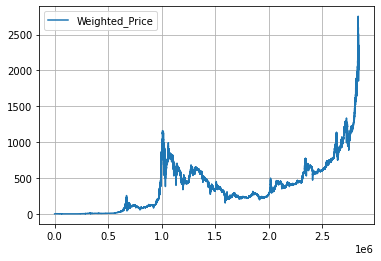

In [59]:
dataset[['Weighted_Price']].plot(grid=True)
plt.show()